### Setup

In [ ]:
f

##### Load Repository

In [ ]:
%reset -f

If not already in google colab, use this link to open notebook there

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cowusuansah/cba-mutant-fba-analysis/blob/main/analysis.ipynb)

In [ ]:
!git clone https://github.com/cowusuansah/cba-mutant-fba-analysis.git

In [ ]:
working_directory = "cba-mutant-fba-analysis"

##### Setup cobrapy

In [ ]:
pip install cobra==0.29.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 51.6 MB/s eta 0:00:00


In [ ]:
# Standard library imports
import os
import csv
import copy
from copy import deepcopy
from collections import defaultdict

# Scientific and data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# COBRA and metabolic modeling libraries
import cobra
from cobra.io import load_model, read_sbml_model, save_json_model
from cobra.flux_analysis import find_blocked_reactions
import gurobipy

In [ ]:
epsilon = np.finfo(float).eps # to keep from dividing by 0

##### Functions

In [ ]:
# @title
#sets fluxes through exchange reactions to 0
def no_intake(my_model):
    """
    Sets lower bounds of all exchange reactions to zero, preventing any metabolite uptake.

    This function creates a copy of the input model and modifies it by setting the
    lower bounds of all exchange reactions (those with 'EX_' prefix) to zero,
    effectively preventing the model from taking up any external metabolites.

    Parameters
    ----------
    my_model : cobra.Model
        The metabolic model to modify

    Returns
    -------
    cobra.Model
        A copy of the input model with exchange reaction lower bounds set to zero
    """
    my_model_1 = copy.deepcopy(my_model)

    for reaction in my_model_1.reactions:
        if 'EX_' in  reaction.id:
            reaction.lower_bound=0
    return my_model_1

def no_carbon_intake(my_model):
    """
    Sets lower bounds of carbon-containing exchange reactions to zero.

    This function creates a copy of the input model and modifies it by setting the
    lower bounds of exchange reactions for carbon-containing metabolites to zero,
    preventing uptake of carbon sources while allowing uptake of other nutrients.

    Parameters
    ----------
    my_model : cobra.Model
        The metabolic model to modify

    Returns
    -------
    cobra.Model
        A copy of the input model with carbon exchange reaction lower bounds set to zero
    """
    my_model_1 = copy.deepcopy(my_model)

    for reaction in my_model_1.reactions:
        if 'EX_' in  reaction.id:
          exchange_metabolite = my_model_1.metabolites.get_by_id("_".join(reaction.id.split("_")[1:]))
          if 'C' in exchange_metabolite.elements:
            reaction.lower_bound=0
    return my_model_1


def calculate_normalized_difference(x, y):
    """
    Calculates the normalized difference between two numbers.

    The normalized difference is defined as (x-y)/(|x|+|y|), which ranges from -1 to 1.
    Values close to zero indicate similarity, while values close to -1 or 1 indicate
    strong differences. This metric is useful for comparing flux values between models.

    Parameters
    ----------
    x : float
        First number
    y : float
        Second number

    Returns
    -------
    float
        Normalized difference between x and y, or 0 if x and y are very close
    """
    if abs(x-y) < 10**(-6):
      return 0
    else:
      return (x-y)/(abs(x)+abs(y)) #epsilon is a really tiny number of the order ~ 10^-16

def calculate_ratio(x, y):
    """
    Calculates the ratio between two numbers, handling division by zero.

    The ratio is calculated as x/y. To prevent division by zero errors,
    a small epsilon value is added to both numerator and denominator.

    Parameters
    ----------
    x : float
        Numerator
    y : float
        Denominator

    Returns
    -------
    float
        Ratio of x to y, with epsilon adjustment to prevent division by zero
    """
    return (x+epsilon)/(y+epsilon) # to keep from dividing by 0 if y is 0


def calculate_biomass_yields(wt_model, mu_model, biomass_yield_dict):
    """
    Calculates biomass yields for wild-type and mutant models using different methods.

    This function calculates the biomass flux for a wild-type model using parsimonious
    FBA (pFBA), and for a mutant model using both pFBA and MOMA (linear and quadratic).
    The results are stored in the provided dictionary under the 'biomass_reaction' key
    for later comparison and visualization.

    Parameters
    ----------
    wt_model : cobra.Model
        Wild-type metabolic model
    mu_model : cobra.Model
        Mutant metabolic model
    biomass_yield_dict : dict
        Dictionary to store the biomass yields results

    Returns
    -------
    None
        Results are stored in the biomass_yield_dict dictionary
    """
    def run_pfba(model):
        """Run parsimonious FBA on the given model."""
        return cobra.flux_analysis.pfba(model)

    def get_biomass_yield(solution):
        """Extract biomass yield from FBA solution."""
        biomass_rxn = bof_dict[model_name]
        return solution.fluxes[biomass_rxn]

    # --- Compute biomass yields with different methods ---
    # Wild-type pFBA
    pfba_wt_sol = run_pfba(wt_model)
    biomass_wt = get_biomass_yield(pfba_wt_sol)

    # Mutant pFBA
    pfba_mu_sol = run_pfba(mu_model)
    biomass_mu = get_biomass_yield(pfba_mu_sol)

    # Mutant linear MOMA
    moma_lin_sol = cobra.flux_analysis.moma(mu_model, solution=pfba_wt_sol, linear=True)
    biomass_moma_lin = get_biomass_yield(moma_lin_sol)

    # Mutant quadratic MOMA
    moma_nonlin_sol = cobra.flux_analysis.moma(mu_model, solution=pfba_wt_sol, linear=False)
    biomass_moma_nonlin = get_biomass_yield(moma_nonlin_sol)

    # Store biomass yields relative to wild-type
    biomass_yield_dict["biomass_reaction"].append([
        [biomass_wt, biomass_mu],
        [biomass_wt, biomass_moma_lin],
        [biomass_wt, biomass_moma_nonlin]
    ])

    return

def set_nutritional_environment(my_model, my_medium, condition=""):
    """
    Sets up the nutritional environment for a metabolic model by constraining intake fluxes.

    This function dispatches to the appropriate specialized function based on model type:
    - For E. coli models, it calls set_nutritional_environment_ecoli
    - For CBA models, it calls the CBA-specific implementation

    Parameters
    ----------
    my_model : cobra.Model
        The metabolic model to set up
    my_medium : str
        Path to the medium specification file
    condition : str, optional
        Condition specification, "_oxygen_limited" applies oxygen limitation

    Returns
    -------
    cobra.Model
        A copy of the input model with exchange reaction bounds set according to the medium
    """
    if "ecoli" in model_name:
        return set_nutritional_environment_ecoli(my_model, my_medium, condition)
    else:
        return set_nutritional_environment_cba(my_model, my_medium, condition)

def set_nutritional_environment_cba(my_model, my_medium, condition=""):
    """
    Sets up the nutritional environment for Cellulophaga baltica models by constraining intake fluxes.

    This function creates a copy of the metabolic model and sets bounds on exchange reactions
    according to the medium specification provided in the input file. For oxygen-limited
    conditions, it also constrains oxygen uptake to 80% of the maximum predicted by FBA.

    Parameters
    ----------
    my_model : cobra.Model
        The metabolic model to set up
    my_medium : str
        Path to the medium specification file
    condition : str, optional
        Condition specification, "_oxygen_limited" applies oxygen limitation

    Returns
    -------
    cobra.Model
        A copy of the input model with exchange reaction bounds set according to the medium
    """
    model = copy.deepcopy(my_model)
    model_reactions = [item.id for item in model.reactions]
    model = no_intake(model)

    with open(my_medium) as f:
        f.readline()
        for line in f:
            parts = line.split("\t")
            metabolite_id = parts[0]
            exchange_reaction = ["EX_" + metabolite_id + "_e0"]
            min_flux = abs(float(parts[3]))
            max_flux = abs(float(parts[4]))

            for rxn in exchange_reaction:
                if rxn in model_reactions:
                    model.reactions.get_by_id(rxn).bounds = (-max_flux, min_flux)
                else:
                    print(parts[1] + " exchange reaction not found in model")

    # Apply oxygen limitation after growth constraints
    if condition == "_oxygen_limited":
        fba_soln = cobra.flux_analysis.pfba(model)
        oxygen_uptake = 0.8 * fba_soln.fluxes["EX_cpd00007_e0"] # setting to 80% of maximum respiratory capacity predicted by FBA
        model.reactions.get_by_id("EX_cpd00007_e0").bounds = (oxygen_uptake, 100)

    return model

def set_nutritional_environment_ecoli(my_model, my_medium, condition=""):
    """
    Sets up the nutritional environment for E. coli models by constraining intake fluxes.

    This function handles the complexity of mapping ModelSEED metabolite IDs to BiGG IDs
    used in E. coli models. It creates a copy of the model, sets exchange reaction bounds
    according to the medium specification, and handles oxygen limitation if specified.

    Parameters
    ----------
    my_model : cobra.Model
        The E. coli metabolic model to set up
    my_medium : str
        Path to the medium specification file
    condition : str, optional
        Condition specification, "_oxygen_limited" applies oxygen limitation

    Returns
    -------
    cobra.Model
        A copy of the input model with exchange reaction bounds set according to the medium
    """
    model = copy.deepcopy(my_model)
    model_reactions = [item.id for item in model.reactions]
    model = no_carbon_intake(model)

    # Load translation model for mapping ModelSEED IDs to BiGG IDs
    translation_model = read_sbml_model(working_directory + "/models/CBA18_RAST_defined.xml")
    translation_model.solver.configuration.verbosity = 0
    translation_mets = [item.id for item in translation_model.metabolites]

    with open(my_medium) as f:
        f.readline()
        for line in f:
            parts = line.split("\t")

            # Map ModelSEED IDs to BiGG IDs for E. coli model
            if parts[0] + "_c0" in translation_mets:
                bigg_id = translation_model.metabolites.get_by_id(parts[0] + "_c0").annotation.get("bigg.metabolite", None)
                if isinstance(bigg_id, list):
                    exchange_reaction = ["EX_" + item + "_e" for item in bigg_id]
                elif isinstance(bigg_id, str):
                    exchange_reaction = ["EX_" + bigg_id + "_e"]
                else:
                    print(parts[1] + " does not map to a BiGG id in translation model")
                    continue
            elif parts[0] + "_e0" in translation_mets:
                bigg_id = translation_model.metabolites.get_by_id(parts[0] + "_e0").annotation.get("bigg.metabolite", None)
                if isinstance(bigg_id, list):
                    exchange_reaction = ["EX_" + item + "_e" for item in bigg_id]
                elif isinstance(bigg_id, str):
                    exchange_reaction = ["EX_" + bigg_id + "_e"]
                else:
                    print(parts[1] + " does not map to a BiGG id in translation model")
                    continue
            else:
                print(parts[1] + " does not map to a BiGG id in translation model")
                continue

            min_flux = abs(float(parts[3]))
            max_flux = abs(float(parts[4]))

            for rxn in exchange_reaction:
                if rxn in model_reactions:
                    model.reactions.get_by_id(rxn).bounds = (-max_flux, min_flux)
                else:
                    print(parts[1] + " exchange reaction not found in model")

    # Apply oxygen limitation after growth constraints
    if condition == "_oxygen_limited":
        fba_soln = cobra.flux_analysis.pfba(model)
        oxygen_uptake = 0.8 * fba_soln.fluxes["EX_o2_e"] # setting to 80% of maximum respiratory capacity predicted by FBA
        model.reactions.get_by_id("EX_o2_e").bounds = (oxygen_uptake, 100)

    return model

def process_quantitative_growth_data(file_name="growth_and_mutant_data/raw/quantitative_growth.tsv"):
    """
    Process growth rate data and calculate relative growth rates compared to wild-type.

    Reads growth data from TSV, calculates statistics, and normalizes to wild-type (Cba18).
    Results are saved to the growth_and_mutant_data/processed/ directory.
    """
    # Read and clean data
    df = pd.read_csv(file_name, sep="\t", dtype={'Strain_new_name': str})
    df['Strain_new_name'] = df['Strain_new_name'].replace(['1840', '1.84E+03'], '184e1')

    # Calculate statistics by group
    grouped_df = df.groupby(['Strain_new_name', 'C_source'])['r'].agg(['mean', 'std', 'count']).reset_index()
    grouped_df.columns = ['Strain_new_name', 'C_source', 'mean r', 'std r', 'count r']
    grouped_df['sem r'] = grouped_df['std r'] / np.sqrt(grouped_df['count r'])

    # Create pivot tables
    mean_df = grouped_df.pivot(index='Strain_new_name', columns='C_source', values='mean r')
    sem_df = grouped_df.pivot(index='Strain_new_name', columns='C_source', values='sem r')

    # Extract wild-type (Cba18) values for normalization
    cba18_mean = mean_df.loc['Cba18']
    cba18_sem = sem_df.loc['Cba18']

    # Calculate relative growth and propagate uncertainties
    relative_mean_df = mean_df.div(cba18_mean, axis=1)
    uncertainty_relative_mean_df = (sem_df / mean_df).add((cba18_sem / cba18_mean), axis=1) * relative_mean_df

    def save_tsv(df, filename):
      df.to_csv(filename, sep='\t', float_format='%.2f')

    # Save results to files
    save_tsv(mean_df, 'growth_and_mutant_data/processed/growth.tsv')
    save_tsv(sem_df, 'growth_and_mutant_data/processed/growth_uncertainty.tsv')
    save_tsv(relative_mean_df, 'growth_and_mutant_data/processed/relative_growth.tsv')
    save_tsv(uncertainty_relative_mean_df, 'growth_and_mutant_data/processed/relative_growth_uncertainty.tsv')

def abbreviate_pathways(pathway, length=30):
    """
    Truncate pathway names if they exceed a specified length.

    Used to shorten lengthy pathway names for better display in figures and tables.

    Parameters
    ----------
    pathway : str
        The pathway name to possibly abbreviate
    length : int, optional
        Maximum length before abbreviation, default 30

    Returns
    -------
    str
        Abbreviated pathway name with '...' suffix or the original if short enough
    """
    if len(pathway) > length:
        return pathway[:length] + '...'
    else:
        return pathway


def convert_RAST_to_bigg(my_model, my_dict):
    """
    Convert RAST model identifiers to BiGG identifiers.

    This function translates reaction IDs from the RAST annotation system to BiGG IDs
    by using the annotation information in the model. Useful for visualization with
    tools that require BiGG identifiers.

    Parameters
    ----------
    my_model : cobra.Model
        The model containing the reactions with BiGG annotations
    my_dict : dict
        Dictionary with RAST reaction IDs as keys and values to be mapped

    Returns
    -------
    dict
        Dictionary with BiGG reaction IDs as keys and the original values
    """
    bigg_dict = {}
    for rxn in my_model.reactions:
        bigg_reactions = rxn.annotation.get("bigg.reaction", rxn.id)

        if type(bigg_reactions) == list:
            for bigg_rxn in bigg_reactions:
                if bigg_rxn in bigg_dict: print("duplicate reaction. check manually for issues")
                bigg_dict[bigg_rxn] = my_dict[rxn.id]
        else:
            if bigg_reactions in bigg_dict: print("duplicate reaction. check manually for issues")
            bigg_dict[bigg_reactions] = my_dict[rxn.id]

    return bigg_dict

def remove_c0(my_dict):
    """
    Remove compartment suffix '_c0' from reaction/metabolite IDs in a dictionary.

    This function is used to simplify IDs for visualization or analysis where
    compartment information is not needed.

    Parameters
    ----------
    my_dict : dict
        Dictionary with keys that might contain '_c0' suffixes

    Returns
    -------
    dict
        Dictionary with '_c0' removed from all keys
    """
    return {key.replace("_c0", ""): my_dict[key] for key in my_dict.keys()}

def add_c0(my_dict):
    """
    Add cytosolic compartment suffix '_c0' to reaction IDs that need it.

    This function identifies reaction IDs that should have compartment information
    (those starting with 'rxn' or 'DM_cpd') and adds the cytosolic compartment
    suffix '_c0' if it's not already present.

    Parameters
    ----------
    my_dict : dict
        Dictionary with keys that might need '_c0' suffixes added

    Returns
    -------
    dict
        Dictionary with '_c0' added to appropriate keys
    """
    new_dict = {}
    for key in my_dict.keys():
        # Check if this is a reaction ID (starts with 'rxn') and doesn't already have a compartment suffix
        if (key.startswith('rxn') or key.startswith("DM_cpd") ) and not ('_c0' in key or '_e0' in key or '_' in key[3:]):
            # Add the '_c0' suffix
            new_dict[key + '_c0'] = my_dict[key]
        else:
            # Keep the key as is
            new_dict[key] = my_dict[key]
    return new_dict


def calculate_production(metabolite, model, flux_distribution):
    """
    Calculate the total production flux for a metabolite in a given flux distribution.

    This function determines how much of a metabolite is being produced across all
    reactions in the model by examining the stoichiometry and flux direction.
    Production occurs when a reaction with positive stoichiometry has positive flux,
    or when a reaction with negative stoichiometry has negative flux.

    Parameters
    ----------
    metabolite : str
        ID of the metabolite to calculate production for
    model : cobra.Model
        The metabolic model containing the reactions
    flux_distribution : dict
        Dictionary mapping reaction IDs to flux values

    Returns
    -------
    float
        Total production flux of the metabolite (mmol/gDW/h)
    """
    total_production = 0.0
    total_consumption = 0.0

    for reaction in model.reactions:
        flux = flux_distribution[reaction.id]
        stoichiometry = reaction.metabolites.get(model.metabolites.get_by_id(metabolite), 0)

        # Only include reactions where the metabolite is produced
        if (stoichiometry > 0 and flux > 0) or (stoichiometry < 0 and flux < 0):
            total_production += stoichiometry * flux

        #reaction were metabolite is consumed
        if (stoichiometry > 0 and flux < 0) or (stoichiometry < 0 and flux > 0):
            total_consumption += stoichiometry * flux

    if round(total_production, 5) != -1 * round(total_consumption, 5):
        print(f"production is {total_production} but consumption is {total_consumption} for {metabolite}")

    return total_production

### Run Simulations (Takes ~2 mins if data is already stored. Run before visualizing results)

In [ ]:
#@markdown Load model and add threonine adolase (present in CBA18 but excluded from KBase model)

model_name = "CBA18_RAST_defined" #@param ["CBA18_RAST_defined", "ecoli/iML1515"] {allow-input: false}

file_name = working_directory + "/models/" + model_name + ".xml"

model_0 = read_sbml_model(file_name)
model_0.solver.configuration.verbosity = 0

curation = "_add_threonine_adolase" #@param ["", "_add_threonine_adolase"] {allow-input: false}

# Manual curation - adding threonine aldolase reaction
if curation == "_add_threonine_adolase" and "ecoli" not in model_name:
    # Load E. coli RAST model to get the threonine aldolase reaction
    ecoli_RAST = read_sbml_model(working_directory + "/models/ecoli/ecoliRAST.xml")

    # Document the reaction being added
    threonine_aldolase = ecoli_RAST.reactions.get_by_id("rxn00541_c0")
    print(f"Adding threonine aldolase reaction:")
    print(f"  - Name: {threonine_aldolase.name}")
    print(f"  - ID: {threonine_aldolase.id}")
    print(f"  - Kegg ID: {threonine_aldolase.annotation['kegg.reaction']}")

    # Add the reaction to the model
    model_0.add_reactions([threonine_aldolase])

    # Add gene association
    model_0.reactions.get_by_id("rxn00541_c0").gene_reaction_rule = "M666_RS13845"
    print(f"  - Associated with gene: M666_RS13845")

model_0.optimize();

print("Model Name: " + model_name)

# Display the model object
model_0

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2604132
Academic license 2604132 - for non-commercial use only - registered to ow___@buckeyemail.osu.edu


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Adding threonine aldolase reaction:
  - Name: L-threonine acetaldehyde-lyase (glycine-forming) [c0]
  - ID: rxn00541_c0
  - Kegg ID: R00751
  - Associated with gene: M666_RS13845
Model Name: CBA18_RAST_defined


Name,
Memory address,7cdd406e5710
Number of metabolites,1200
Number of reactions,1295
Number of genes,848
Number of groups,0
Objective expression,1.0*bio1_biomass - 1.0*bio1_biomass_reverse_6e711
Compartments,"c0, e0"


In [ ]:
#@title {display-mode: "form"}
#@markdown Display metabolic genes associated with phage resistance (only works when the CBA18 model is loaded)

if "ecoli" not in model_name:
    # Genes associated with phage resistance
    full_set_of_mutations = set([
        "M666_RS07700", "M666_RS16755", "M666_RS20120", "M666_RS18590",
        "M666_RS01685", "M666_RS02270", "M666_RS02280", "M666_RS02275",
        "M666_RS15505", "M666_RS01050", "M666_RS01055", "M666_RS02285",
        "M666_RS01425", "M666_RS01720", "M666_RS08865", "M666_RS13880",
        "M666_RS17370"
    ])

    # Find which mutation genes are present in the model
    mutant_genes_in_model = full_set_of_mutations.intersection(set([i.id for i in model_0.genes]))

    # Automatically extract reactions associated with mutant genes
    mutant_reactions = []
    for reaction in model_0.reactions:
        # Get the genes associated with this reaction
        reaction_genes = [gene.id for gene in reaction.genes]
        # Check if any mutant genes are associated with this reaction
        if any(gene in mutant_genes_in_model for gene in reaction_genes):
            mutant_reactions.append(reaction.id)


    # Create dictionary with information about mutant reactions
    mutant_info_dict = {
        "name": [model_0.reactions.get_by_id(i).name for i in mutant_reactions],
        "gene_reaction_rule": [model_0.reactions.get_by_id(i).gene_reaction_rule for i in mutant_reactions],
        "associated_mutant_genes": [", ".join(set(g.id for g in model_0.reactions.get_by_id(i).genes if g.id in mutant_genes_in_model)) for i in mutant_reactions]
    }

    # Add BioCyc and KEGG annotations if available
    if all("biocyc" in model_0.reactions.get_by_id(i).annotation for i in mutant_reactions):
        mutant_info_dict["BioCyc"] = [model_0.reactions.get_by_id(i).annotation["biocyc"] for i in mutant_reactions]

    if all("kegg.reaction" in model_0.reactions.get_by_id(i).annotation for i in mutant_reactions):
        mutant_info_dict["KEGG"] = [model_0.reactions.get_by_id(i).annotation["kegg.reaction"] for i in mutant_reactions]

    print(f"Genes associated with phage resistance that are found in model ({len(mutant_genes_in_model)}): {', '.join(sorted(list(mutant_genes_in_model)))}")
    print(f"\nAssociated Reactions ({len(mutant_reactions)}):")
    display(pd.DataFrame(mutant_info_dict, index=mutant_reactions))

Genes associated with phage resistance that are found in model (3): M666_RS13880, M666_RS15505, M666_RS17370

Associated Reactions (4):


,name,gene_reaction_rule,associated_mutant_genes,BioCyc,KEGG
rxn01101_c0,3-Phospho-D-glycerate:NAD+ 2-oxidoreductase [c0],M666_RS06810 and M666_RS17370 and M666_RS17960,M666_RS17370,META:PGLYCDEHYDROG-RXN,R01513
rxn01485_c0,"D-Glucosamine 1-phosphate 1,6-phosphomutase [c0]",M666_RS15505,M666_RS15505,META:5.4.2.10-RXN,R02060
rxn01329_c0,"D-mannose 6-phosphate 1,6-phosphomutase [c0]",M666_RS15505,M666_RS15505,META:PHOSMANMUT-RXN,R01818
rxn00274_c0,Acetyl-CoA:glycine C-acetyltransferase [c0],M666_RS04130 and M666_RS13880,M666_RS13880,META:AKBLIG-RXN,R00371


In [ ]:
#@title {display-mode: "form"}
#@markdown Load experimental growth rate data and pathway annotations needed for analysis:
#@markdown - Processes quantitative growth data for wild-type and mutant strains
#@markdown - Loads KEGG pathway annotations for metabolic reactions
#@markdown - Loads BioCyc/MetaCyc pathway annotations for metabolic reactions

# --- Define media conditions based on model type ---
if model_name != "ecoli/iML1515":
    defined_mets = ["D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid", "Salicin"]
else:
    defined_mets = ["D-Glucose", "D-Lactose", "Maltose", "D-Fructose", "L-Glutamic-acid"]

# Mapping of mutant IDs to the reactions they affect within the model
id_mapping = {"184f1": "rxn01101_c0"}

# --- Process and load growth rate data ---
process_quantitative_growth_data()

rel_growth = pd.read_csv("growth_and_mutant_data/processed/relative_growth.tsv", sep="\t", index_col=0)
rel_growth_unc = pd.read_csv("growth_and_mutant_data/processed/relative_growth_uncertainty.tsv", sep="\t", index_col=0)
abs_growth = pd.read_csv("growth_and_mutant_data/processed/growth.tsv", sep="\t", index_col=0)
abs_growth_unc = pd.read_csv("growth_and_mutant_data/processed/growth_uncertainty.tsv", sep="\t", index_col=0)

# Standardize column names in growth data
new_columns = {
    "D-glucose": "D-Glucose", "alpha-Lactose": "D-Lactose", "maltose": "Maltose",
    "sucrose": "Sucrose", "D-fructose": "D-Fructose", "L-glutamic acid": "L-Glutamic-acid",
    "salicin": "Salicin", "MLB": "LB_wo_glycine"
}

rel_growth.rename(columns=new_columns, inplace=True)
rel_growth_unc.rename(columns=new_columns, inplace=True)
abs_growth.rename(columns=new_columns, inplace=True)
abs_growth_unc.rename(columns=new_columns, inplace=True)

# Filter datasets to include only relevant media conditions and mutants
rel_growth = rel_growth[defined_mets + ["LB_wo_glycine"]].loc[list(id_mapping.keys())]
rel_growth_unc = rel_growth_unc[defined_mets + ["LB_wo_glycine"]].loc[list(id_mapping.keys())]
abs_growth_wt = abs_growth[defined_mets + ["LB_wo_glycine"]].loc[["Cba18"]]
abs_growth_wt_unc = abs_growth_unc[defined_mets + ["LB_wo_glycine"]].loc[["Cba18"]]

# --- Load KEGG pathway annotations ---
kegg_reaction_module_dict = defaultdict(list)
kegg_module_reaction_dict = defaultdict(set)
kegg_module_description = {}

with open("pathways/kegg/kegg_reaction_module.tsv", "r") as f:
    for line in f:
        reaction, module = line.strip("\n").split("\t")
        kegg_reaction_module_dict[reaction.strip("rn:")].append(module.strip("md:"))
        kegg_module_reaction_dict[module.strip("md:")].add(reaction.strip("rn:"))

with open("pathways/kegg/kegg_modules.tsv", "r") as f:
    for line in f:
        module, description = line.strip("\n").split("\t")
        kegg_module_description[module] = description

# Extract KEGG annotations from model reactions
kegg_annotations = {
    i.id: i.annotation["kegg.reaction"] if isinstance(i.annotation["kegg.reaction"], list)
          else [i.annotation["kegg.reaction"]]
    for i in model_0.reactions if "kegg.reaction" in i.annotation
}
kegg_reactions_in_model = set().union(*list(kegg_annotations.values()))

# --- Load BioCyc/MetaCyc pathway annotations ---
metacyc_reaction_module_dict = defaultdict(list)
metacyc_module_reaction_dict = defaultdict(set)
metacyc_module_description = {}

with open("pathways/metacyc/pathway_reactions.tsv", "r") as f:
    for line in f:
        module, reaction_string = line.strip("\n").split("\t")
        reactions = reaction_string.split(" // ")

        for rxn in reactions:
            metacyc_reaction_module_dict[rxn].append(module)
        metacyc_module_reaction_dict[module] = set(reactions)

with open("pathways/metacyc/pathway_names.tsv", "r") as f:
    for line in f:
        module, description = line.strip("\n").split("\t")
        metacyc_module_description[module] = description

# Extract BioCyc annotations from model reactions
metacyc_annotations = {
    i.id: [j.strip("META:") for j in i.annotation['biocyc']] if isinstance(i.annotation['biocyc'], list)
          else [i.annotation['biocyc'].strip("META:")]
    for i in model_0.reactions if 'biocyc' in i.annotation
}
metacyc_reactions_in_model = set().union(*list(metacyc_annotations.values()))

In [ ]:
#@title {display-mode: "form"}
#@markdown Creates mutant model by knocking out rxn01101_c0

# --- Define key simulation parameters ---
CBA_mutant = "rxn01101_c0" #@param ["rxn01101_c0"] {allow-input: false}
media_condition = "_oxygen_limited" #@param ["", "_oxygen_limited"]

# Mapping between RAST and BiGG identifiers (only need phosphoglycerate dehydrogenase)
rast_to_bigg = {"rxn01101_c0": "PGCD"}

# --- Create wild-type and mutant models ---
model_1 = copy.deepcopy(model_0)
mutant_model = deepcopy(model_1)
wild_type_model = deepcopy(model_1)

# Apply the knockout to the mutant model
if "ecoli" not in model_name:
    # For CBA models
    mutant_model.reactions.get_by_id(CBA_mutant).bounds = (0, 0)
else:
    # For E. coli models
    mutant_model.reactions.get_by_id(rast_to_bigg[CBA_mutant]).bounds = (0, 0)

Read LP format model from file /tmp/tmpar2p3vvp.lp
Reading time = 0.02 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmp3rqu_42_.lp
Reading time = 0.02 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpxfa3ynj5.lp
Reading time = 0.02 seconds
: 1200 rows, 2590 columns, 11374 nonzeros


In [ ]:
#@title {display-mode: "form"}
#@markdown Extract metabolites in biomass objective for visualization later

# Dictionary mapping model names to their biomass objective function reactions
bof_dict = {"CBA18_RAST_defined":"bio1_biomass",
            "ecoli/iML1515":"BIOMASS_Ec_iML1515_core_75p37M"}

# Dictionary mapping biomass reactions to their associated mutant reactions
bof_to_mutant_rxns = {"bio1_biomass": list(rast_to_bigg.keys()),
                      "BIOMASS_Ec_iML1515_core_75p37M": list(rast_to_bigg.values())}

# Extract biomass precursors based on model type
if "ecoli" in model_name:
  # For E. coli iML1515 model, get all metabolites in biomass reaction
  all_precursors = [met.id for met in model_1.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M").metabolites]


else:
  # For CBA18 model, handle biomass precursors in a more detailed way
  # Define macromolecule components and their synthesis reactions
  macro_mols = {'DNA': 'cpd11461_c0',
                'Protein': 'cpd11463_c0',
                'mRNA': 'cpd11462_c0',
                'Biomass':'cpd11416_c0'}

  make_macro = {'DNA': 'rxn05294_c0',
                'Protein': 'rxn05296_c0',
                'mRNA': 'rxn05295_c0',
                'Biomass':'bio1_biomass'}

  # Extract biomass precursors from the main biomass reaction
  biomass_mets_all = model_1.reactions.get_by_id("bio1_biomass").metabolites
  biomass_mets = {item:biomass_mets_all[item] for item in biomass_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  biomass_mets_ids = {item.id:(item.name, biomass_mets[item]) for item in biomass_mets.keys()}
  biomass_precursors = set(biomass_mets_ids.keys())

  # Extract mRNA synthesis precursors
  mRNA_mets_all = model_1.reactions.get_by_id("rxn05295_c0").metabolites
  mRNA_mets = {item:mRNA_mets_all[item] for item in mRNA_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  mRNA_mets_ids = {item.id:(item.name, mRNA_mets[item]) for item in mRNA_mets.keys()}
  mRNA_precursors = set(mRNA_mets_ids.keys())

  # Extract protein synthesis precursors
  prot_mets_all = model_1.reactions.get_by_id("rxn05296_c0").metabolites
  prot_mets = {item:prot_mets_all[item] for item in prot_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  prot_mets_ids = {item.id:(item.name, prot_mets[item]) for item in prot_mets.keys()}
  prot_precursors = set(prot_mets_ids.keys())

  # Extract DNA synthesis precursors
  DNA_mets_all = model_1.reactions.get_by_id("rxn05294_c0").metabolites
  DNA_mets = {item:DNA_mets_all[item] for item in DNA_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  DNA_mets_ids = {item.id:(item.name, DNA_mets[item]) for item in DNA_mets.keys()}
  DNA_precursors = set(DNA_mets_ids.keys())

  # Combine all precursors from different macromolecule synthesis pathways
  all_precursors = list(biomass_precursors | mRNA_precursors | prot_precursors | DNA_precursors)


In [ ]:
#@title {display-mode: "form"}
#@markdown Calculate biomass production yield

# Configuration parameter for controlling when to save new tables
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

# Calculate biomass yields for each media condition
for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

    # Set up file paths and initialize data structure
    media_file =  f"growth_media/defined/" + met + ".tsv"
    biomass_yield_dict = defaultdict(list)
    biomass_yield_file = working_directory + f"/simulations/" + model_name + curation + "/biomass_yield/" + met.split("/")[-1] + "_" + CBA_mutant + media_condition + ".json"

    # Only calculate and save if requested or if file doesn't exist
    if save_new_tables == "yes" or (not os.path.exists(biomass_yield_file) and save_new_tables != "no"):

      # Set up models with appropriate nutritional environment
      wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
      mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

      # Calculate biomass yields and save results
      calculate_biomass_yields(wild_type_model_x, mutant_model_x, biomass_yield_dict)

      with open(biomass_yield_file, 'w') as f:
        json.dump(biomass_yield_dict, f)

In [ ]:
#@title {display-mode: "form"}
#@markdown Generate flux distribution data for visualization in escher

# Configuration parameter for controlling when to save new tables
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

# Save the model for escher visualization
save_json_model(wild_type_model, working_directory + f"/simulations/" + model_name + curation + "/escher_fluxes/model.json")

# Process each media condition
for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

  # Set up file paths
  media_file =  f"growth_media/defined/" + met + ".tsv"
  escher_flux_file = working_directory + f"/simulations/" + model_name + curation + "/escher_fluxes/" + met + "/" + CBA_mutant + media_condition

  # Only calculate and save if requested or if file doesn't exist
  if save_new_tables == "yes" or (not os.path.exists(escher_flux_file+ "_norm_diff.json") and save_new_tables != "no"):
    # Set up models with appropriate nutritional environment
    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    # Calculate wild-type fluxes using pFBA
    wt_flux_data = dict(cobra.flux_analysis.pfba(wild_type_model_x).fluxes)

    # Save wild-type fluxes in appropriate format
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_WT.json", 'w') as f:
        json.dump(remove_c0(wt_flux_data), f)
      with open(escher_flux_file + "_WT_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, wt_flux_data), f)
    else:
      with open(escher_flux_file + "_WT.json", 'w') as f:
        json.dump(wt_flux_data, f)

    # Calculate mutant fluxes using MOMA
    mu_flux_data_from_MOMA = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False).fluxes)

    # Save mutant fluxes in appropriate format
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_MU.json", 'w') as f:
        json.dump(remove_c0(mu_flux_data_from_MOMA), f)
      with open(escher_flux_file + "_MU_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(mutant_model_x, mu_flux_data_from_MOMA), f)
    else:
      with open(escher_flux_file + "_MU.json", 'w') as f:
        json.dump(mu_flux_data_from_MOMA, f)

    # Calculate and save flux differences
    diff_flux_data = {key: mu_flux_data_from_MOMA[key] - wt_flux_data[key] for key in wt_flux_data.keys()}
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_diff.json", 'w') as f:
        json.dump(remove_c0(diff_flux_data), f)
      with open(escher_flux_file + "_diff_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, diff_flux_data), f)
    else:
      with open(escher_flux_file + "_diff.json", 'w') as f:
        json.dump(diff_flux_data, f)

    # Calculate and save normalized flux differences
    norm_diff_flux_data = {key:  calculate_normalized_difference(mu_flux_data_from_MOMA[key], wt_flux_data[key])  for key in wt_flux_data.keys()}
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_norm_diff.json", 'w') as f:
        json.dump(remove_c0(norm_diff_flux_data), f)
      with open(escher_flux_file + "_norm_diff_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, norm_diff_flux_data), f)
    else:
      with open(escher_flux_file + "_norm_diff.json", 'w') as f:
        json.dump(norm_diff_flux_data, f)


In [ ]:
#@title {display-mode: "form"}
#@markdown Calculate and stores flux differences between wild-type and mutant models across different media conditions.

save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

# Define output file paths for different flux comparison metrics
flux_file_diff = working_directory + f"/simulations/" + model_name + curation + "/fluxes/" + CBA_mutant + "_difference" + media_condition + ".json"
flux_file_norm_diff = working_directory + f"/simulations/" + model_name + curation + "/fluxes/" + CBA_mutant + "_normalized_difference" + media_condition + ".json"
flux_file_ratio = working_directory + f"/simulations/" + model_name + curation + "/fluxes/" + CBA_mutant + "_ratio" + media_condition + ".json"

# Check if output files already exist
flux_file_path_exists = os.path.exists(flux_file_diff) and os.path.exists(flux_file_norm_diff) and os.path.exists(flux_file_ratio)

# Initialize data structures to store flux comparison results
rxn_fluxes_diff = defaultdict(list)
rxn_fluxes_norm_diff = defaultdict(list)
rxn_fluxes_ratio = defaultdict(list)

# Define reaction categories for analysis
exchange_w_C = [i.id for i in wild_type_model.boundary if "C" in wild_type_model.metabolites.get_by_id("_".join(i.id.split("_")[1:])).elements]
exchange_all = [i.id for i in wild_type_model.boundary]
all_rxns = [i.id for i in wild_type_model.reactions]


if save_new_tables == "yes" or (not flux_file_path_exists and save_new_tables != "no"):
  # Store reaction IDs in the result dictionaries for reference
  rxn_fluxes_diff["all_rxns"] = rxn_fluxes_norm_diff["all_rxns"] = rxn_fluxes_ratio["all_rxns"] = all_rxns
  rxn_fluxes_diff["boundary"] = rxn_fluxes_norm_diff["boundary"] = rxn_fluxes_ratio["boundary"] = exchange_w_C
  rxn_fluxes_diff["internal"] = rxn_fluxes_norm_diff["internal"] = rxn_fluxes_ratio["internal"] = list(set(all_rxns) - set(exchange_all))

  # Analyze each media condition
  for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:
    # Set up nutritional environment
    media_file =  f"growth_media/defined/" + met + ".tsv"
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)
    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)

    # Calculate wild-type and mutant fluxes using different methods
    # Wild-type using pFBA
    fba_solution_wt = cobra.flux_analysis.pfba(wild_type_model_x).fluxes

    # Mutant using pFBA
    fba_solution_mut = cobra.flux_analysis.pfba(mutant_model_x).fluxes

    # Mutant using linear MOMA
    moma_linear_soln = cobra.flux_analysis.moma(model=mutant_model_x,
                                                solution=cobra.flux_analysis.pfba(wild_type_model_x),
                                                linear=True).fluxes
    # Mutant using quadratic MOMA
    moma_soln = cobra.flux_analysis.moma(model=mutant_model_x,
                                         solution=cobra.flux_analysis.pfba(wild_type_model_x),
                                         linear=False).fluxes

    # Calculate flux differences for each reaction
    for rxn in all_rxns:
      # Calculate absolute flux differences (Mutant - WT)
      fba_diff = (fba_solution_mut[rxn]-fba_solution_wt[rxn])
      moma_linear_diff= (moma_linear_soln[rxn]-fba_solution_wt[rxn])
      moma_diff = (moma_soln[rxn]-fba_solution_wt[rxn])

      # Calculate normalized flux differences
      fba_norm_diff = calculate_normalized_difference(fba_solution_mut[rxn],fba_solution_wt[rxn])
      moma_linear_norm_diff= calculate_normalized_difference(moma_linear_soln[rxn],fba_solution_wt[rxn])
      moma_norm_diff = calculate_normalized_difference(moma_soln[rxn],fba_solution_wt[rxn])

      # Calculate flux ratios (Mutant/WT)
      fba_ratio = calculate_ratio(fba_solution_mut[rxn],fba_solution_wt[rxn])
      moma_linear_ratio= calculate_ratio(moma_linear_soln[rxn],fba_solution_wt[rxn])
      moma_ratio = calculate_ratio(moma_soln[rxn],fba_solution_wt[rxn])

      # Store results for each reaction ([FBA, linear MOMA, quadratic MOMA])
      rxn_fluxes_diff[met].append([fba_diff, moma_linear_diff, moma_diff])
      rxn_fluxes_norm_diff[met].append([fba_norm_diff, moma_linear_norm_diff, moma_norm_diff])
      rxn_fluxes_ratio[met].append([fba_ratio, moma_linear_ratio, moma_ratio])

  # Save results to JSON files
  with open(flux_file_diff, 'w') as f:
    json.dump(rxn_fluxes_diff, f)

  with open(flux_file_norm_diff, 'w') as f:
    json.dump(rxn_fluxes_norm_diff, f)

  with open(flux_file_ratio, 'w') as f:
    json.dump(rxn_fluxes_ratio, f)


In [ ]:
#@title {display-mode: "form"}
#@markdown Calculates the production flux (turnover rate) of all metabolites in the model

save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

# Define output file path for metabolite production results
met_production_file = working_directory + f"/simulations/" + model_name + curation + "/metabolite_production/" + CBA_mutant + media_condition + ".json"
met_production_dict = defaultdict(list)

# Get all metabolites in the model
all_metabolites = [i.id for i in model_0.metabolites]

# Store reference information in the results dictionary
met_production_dict["all_metabolites"] = all_metabolites
met_production_dict["frameworks"] = ["Wild Type FBA", "Mutant FBA", "Linear MOMA", "MOMA"]

# Only calculate and save if requested or if file doesn't exist
if save_new_tables == "yes" or (not os.path.exists(met_production_file) and save_new_tables != "no"):

  # Analyze each media condition
  for c_source in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

    # Set up the nutritional environment
    media_file =  f"growth_media/defined/" + c_source + ".tsv"
    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    # Calculate flux distributions using different methods

    # Wild-type using pFBA
    fba_solution_wt = dict(cobra.flux_analysis.pfba(wild_type_model_x).fluxes)

    # Mutant using pFBA
    fba_solution_mut = dict(cobra.flux_analysis.pfba(mutant_model_x).fluxes)

    # Mutant using linear MOMA
    moma_linear_soln = dict(cobra.flux_analysis.moma(model=mutant_model_x,
                                                     solution=cobra.flux_analysis.pfba(wild_type_model_x),
                                                     linear=True).fluxes)

    # Mutant using quadratic MOMA
    moma_soln = dict(cobra.flux_analysis.moma(model=mutant_model_x,
                                              solution=cobra.flux_analysis.pfba(wild_type_model_x),
                                              linear=False).fluxes)

    # Calculate production flux for each metabolite under each condition
    for met_id in all_metabolites:
      # Calculate total production flux (turnover) for each metabolite
      fba_wt_production = calculate_production(met_id, wild_type_model_x, fba_solution_wt)
      fba_mutant_production = calculate_production(met_id, mutant_model_x, fba_solution_mut)
      moma_linear_production = calculate_production(met_id, mutant_model_x, moma_linear_soln)
      moma_production = calculate_production(met_id, mutant_model_x, moma_soln)

      # Store results for each metabolite [WT FBA, Mutant FBA, Mutant Linear MOMA, Mutant Quadratic MOMA]
      met_production_dict[c_source].append([fba_wt_production, fba_mutant_production, moma_linear_production, moma_production])

  # Save results to JSON file
  with open(met_production_file, 'w') as f:
    json.dump(met_production_dict, f)

In [ ]:
#@title {display-mode: "form"}
#@markdown Identify and save information about blocked reactions (reactions that cannot carry flux under any condition) and dead-end metabolites (metabolites that cannot be produced or consumed)

save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

# Define output file paths
blocked_rxns_file = working_directory + "/models/model_diagnostics/blocked_reactions.tsv"
dead_end_mets_file = working_directory + "/models/model_diagnostics/dead_end_metabolites.tsv"

# Only calculate and save if requested or if files don't exist
if save_new_tables == "yes" or (not os.path.exists(blocked_rxns_file) and save_new_tables != "no") and "ecoli" not in model_name:
  # Find reactions that cannot carry flux in the network
  # Setting open_exchanges=True ensures that reactions blocked reactions are computed over all possible media environments
  blocked_rxns = find_blocked_reactions(model_0, open_exchanges=True)

  # Identify metabolites that cannot be produced or consumed
  # A metabolite is a dead-end if all of its associated reactions are blocked
  dead_end_mets = [
      met for met in model_0.metabolites
      if met.reactions and all(rxn in blocked_rxns for rxn in [i.id for i in met.reactions])
  ]

  # Save dead-end metabolites to TSV file
  with open(dead_end_mets_file , 'w', newline='') as tsvfile:
      writer = csv.writer(tsvfile, delimiter='\t')
      writer.writerow(["metabolite_id", "metabolite_name"])
      for met in dead_end_mets:
          writer.writerow([met.id, met.name])

  # Save blocked reactions to TSV file
  with open(blocked_rxns_file , 'w', newline='') as tsvfile:
      writer = csv.writer(tsvfile, delimiter='\t')
      writer.writerow(["reaction_id", "reaction_name"])
      for rxn in blocked_rxns:
          writer.writerow([model_0.reactions.get_by_id(rxn).id, model_0.reactions.get_by_id(rxn).name])

In [ ]:
#@title {display-mode: "form"}
#@markdown Processes the KBase gapfilling report and extract information about reactions added during the gapfilling process. Gapfilling was necessary necessary to enable model growth on experimentally verified carbon sources

save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

# Define file paths for input and output
kbase_gapfilling_file = working_directory + "/models/curation/gapfilling_reactions.json"
gapfilling_file = working_directory + "/models/curation/gapfilling_reactions.tsv"

# Only process if requested or if file doesn't exist and not an E. coli model
if (save_new_tables == "yes" or (not os.path.exists(gapfilling_file) and save_new_tables != "no")) and "ecoli" not in model_name:
  # Read and process the gapfilling report
  with open(kbase_gapfilling_file, "r") as f:
      data = json.load(f)
      gapfilling_report = pd.DataFrame(data)

  # Extract relevant columns and save to TSV
  gapfilling_report[["reaction_id", "media", "gapfilling_sensitivity_id"]].to_csv(
      gapfilling_file,
      sep="\t",
      index=False)

  # Calculate and display summary statistics
  number_of_gapfilling_reactions = len(set(gapfilling_report["reaction_id"]))
  print("Number of gapfilling reactions: " + str(number_of_gapfilling_reactions))

In [ ]:
#@title {display-mode: "form"}
#@markdown  Calculate the ratio of acetate secretion in the mutant compared to wild-type in CBA when grown on glucose.

if "ecoli" not in model_name and media_condition == "_oxygen_limited":
  # Use glucose as the carbon source
  media_file =  f"growth_media/defined/D-Glucose.tsv"

  # Set up models with appropriate nutritional environment
  wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition);
  mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

  # Calculate wild-type flux distribution using pFBA
  fba_solution_wt = cobra.flux_analysis.pfba(wild_type_model_x).fluxes

  # Calculate mutant flux distribution using MOMA
  cobra.flux_analysis.add_moma(model=mutant_model_x,
                              solution=cobra.flux_analysis.pfba(wild_type_model_x),
                              linear=False)

  moma_soln = mutant_model_x.optimize().fluxes

  # C. baltica acetate exchange reaction ID
  acetate_id = "EX_cpd00029_e0"
  acetate_production_ratio = dict(moma_soln)[acetate_id] / dict(fba_solution_wt)[acetate_id]

  # Print results
  print(f"At 80% of the full respiratory capacity, the acetate production ratio in the mutant relative to the wild-type is {acetate_production_ratio:.3f}")

Read LP format model from file /tmp/tmpzqopt2ef.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpcjy738mw.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmp4078ur4s.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpmci9e4kh.lp
Reading time = 0.02 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
At 80% of the full respiratory capacity, the acetate production ratio in the mutant relative to the wild-type is 1.210


### Visualize Results

#### Biomass production in Mutant vs WT

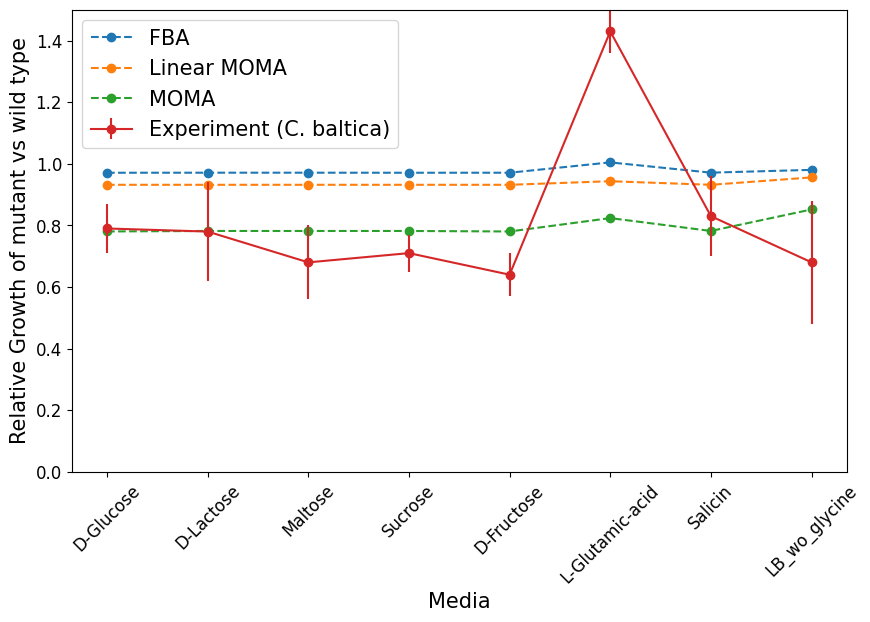

In [ ]:
#@title {display-mode: "form"}
#@markdown Biomass production in Mutant vs WT

KO_mutant = "rxn01101_c0" #@param ["rxn01101_c0"]{allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

# Dictionary mapping approach names to their indices in the data structure
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}

# List of media conditions to analyze
media_list = defined_mets + ["LB_wo_glycine"]

# Dictionary to store biomass yield data for each media condition
biomass_yield_results = {}

# Load biomass yield data for each media condition
for media in media_list:
  result_file_path = working_directory + f"/simulations/" + model_name + curation + "/biomass_yield/" + media + "_" + KO_mutant + media_condition + ".json"
  with open(result_file_path, 'r') as f:
    biomass_yield_results[media] = json.load(f)

# Process data to calculate relative growth ratios
relative_growth_ratios = []

for media in media_list:
  biomass_yield_data = biomass_yield_results[media]['biomass_reaction'][0]  # Extract biomass yield data

  # Calculate mutant-to-wildtype ratios for all three approaches (FBA, Linear MOMA, MOMA)
  mutant_to_wildtype_ratio = [
      (biomass_yield_data[0][1] + epsilon) / (biomass_yield_data[0][0] + epsilon),  # FBA
      (biomass_yield_data[1][1] + epsilon) / (biomass_yield_data[1][0] + epsilon),  # Linear MOMA
      (biomass_yield_data[2][1] + epsilon) / (biomass_yield_data[2][0] + epsilon)   # MOMA
  ]

  relative_growth_ratios.append(mutant_to_wildtype_ratio)

# Reshape data for plotting
relative_growth_array = np.array(relative_growth_ratios).reshape(-1, 3).T

# Create visualization if requested
if create_figure == "yes" and "ecoli" not in model_name:
  plt.figure(figsize=(10, 6))

  # Extract experimental growth values and uncertainties
  experimental_growth_values = list(rel_growth[media_list].loc[list(id_mapping.keys())].loc["184f1"])
  experimental_uncertainties = list(rel_growth_unc[media_list].loc[list(id_mapping.keys())].loc["184f1"])

  # Plot computational predictions for each approach
  approach_labels = ["FBA", "Linear MOMA", "MOMA"]
  for i, label in enumerate(approach_labels):
    plt.plot(media_list, relative_growth_array[i], marker='o', label=label, linestyle='--')

  # Plot experimental data with error bars
  plt.errorbar(media_list, experimental_growth_values, yerr=experimental_uncertainties,
               marker='o', label="Experiment (C. baltica)")

  # Format the plot
  plt.xlabel('Media', fontsize=15)
  plt.ylabel("Relative Growth of mutant vs wild type", fontsize=15)
  plt.xticks(rotation=45, fontsize=12)
  plt.yticks(fontsize=12)
  plt.ylim(0, 1.5)
  plt.legend(fontsize=15)

#### Fluxes in Mutant vs WT

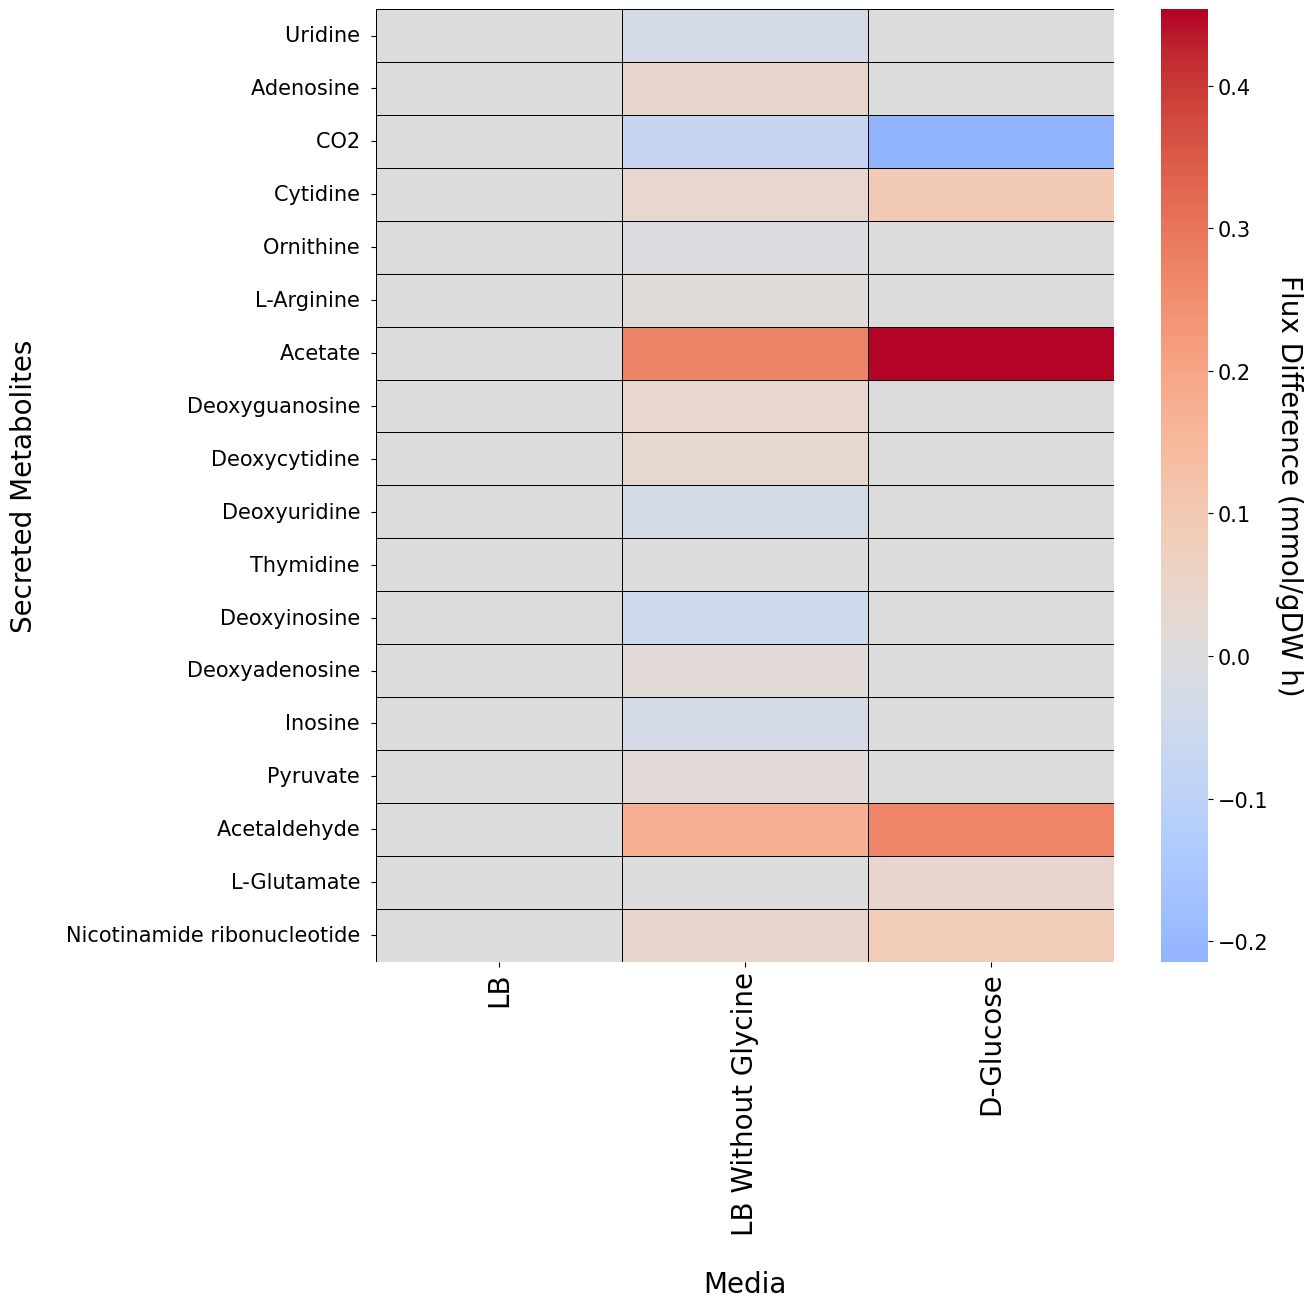

In [ ]:
#@title {display-mode: "form"}
#@markdown Heatmap showing boundary fluxes in the wt vs mutant

# The mutant being analyzed (phosphoglycerate dehydrogenase, L-serine biosynthesis)
mutant = "rxn01101_c0" #@param ["rxn01101_c0"]{allow-input: false}

# Metric for comparison: absolute difference or normalized difference between fluxes
metric = "difference" #@param ["difference", "normalized_difference"] {allow-input: false}

# Option to generate visualization
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

# Analysis configuration
approach = "MOMA" # Most predictive method used for flux prediction in mutant
compartment = "boundary" # Focus on boundary/exchange reactions

# Mappings for labels and approaches
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}
media_list_map = {"LB/LB":"LB", "LB/LB_wo_serine": "LB Without Serine", "LB/LB_wo_glycine":"LB Without Glycine","LB/LB_wo_threonine":"LB Without Threonine",
                  "LB/LB_plus_serine": "LB Plus Serine", "LB/LB_plus_glycine":"LB Plus Glycine", "LB/LB_plus_threonine":"LB Plus Threonine"}

flux_file = working_directory + f"/simulations/" + model_name + curation + "/fluxes/" + mutant + "_" + metric + media_condition + ".json"
difference_flux_file = working_directory + f"/simulations/" + model_name + curation + "/fluxes/" + mutant + "_difference" + media_condition + ".json"

if create_figure == "yes":
  # Combine defined minimal media and complex media with different supplements
  media_list = ["LB/LB", "LB/LB_wo_glycine", "D-Glucose"] #defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  # Load flux data from files
  with open(flux_file, 'r') as f:
    plot_dict = json.load(f)

  with open(difference_flux_file, 'r') as f:
    helper_plot_dict = json.load(f)

  # Filter reactions and prepare data for visualization
  filtered_rxns =[]
  data = []

  for i in range(len(plot_dict["all_rxns"])):
    my_list = []
    my_helper_list = []
    for media in media_list:
      my_list.append(plot_dict[media][i][approach_map[approach]])
      my_helper_list.append(helper_plot_dict[media][i][approach_map[approach]])

    # Only include reactions with non-zero differences between WT and mutant
    # and that are boundary reactions (exchange/secretion)
    if not all(round(abs(element),5) == 0 for element in my_helper_list) and (plot_dict["all_rxns"][i] in plot_dict[compartment]):
      filtered_rxns.append(plot_dict["all_rxns"][i])
      data.append(my_list)

  data_array = np.array(data)

  # Prepare labels for visualization
  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_rxns

  # Create readable metabolite names by removing compartment tags
  row_names = [abbreviate_pathways(model_0.metabolites.get_by_id("_".join(i.split("_")[1:])).name.replace("[e0]","").replace("[c0]","")) for i in filtered_rxns]

  # Create heatmap visualization
  plt.figure(figsize=(14, 14))

  # Generate heatmap with coolwarm colormap centered at zero
  ax = sns.heatmap(data_array, annot=False, fmt=".3f", cmap='coolwarm', center=0, cbar=True, linewidths=.5, linecolor='black',
              xticklabels=col_names, yticklabels=row_names, annot_kws={"size": 10})

  # Format axis labels and ticks
  plt.xticks(rotation=90, fontsize = 20)
  plt.yticks(rotation=0, fontsize = 15)
  plt.xlabel("Media", fontsize=20, labelpad=25)
  plt.ylabel("Secreted Metabolites", fontsize=20, labelpad=20)

  # Configure colorbar appearance and labels
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=15)

  # Set appropriate colorbar label based on metric
  if metric == "difference":
    cbar.ax.set_ylabel('Flux Difference (mmol/gDW h)', rotation=270, fontsize=20, labelpad=25)
  elif metric == "normalized_difference":
    cbar.ax.set_ylabel('Normalized Flux Difference', rotation=270, fontsize=20, labelpad=25)

  # Adjust layout for better display
  fig = plt.gcf()
  fig.tight_layout(pad=4.0)

  plt.show()


<Figure size 1800x1980 with 0 Axes>

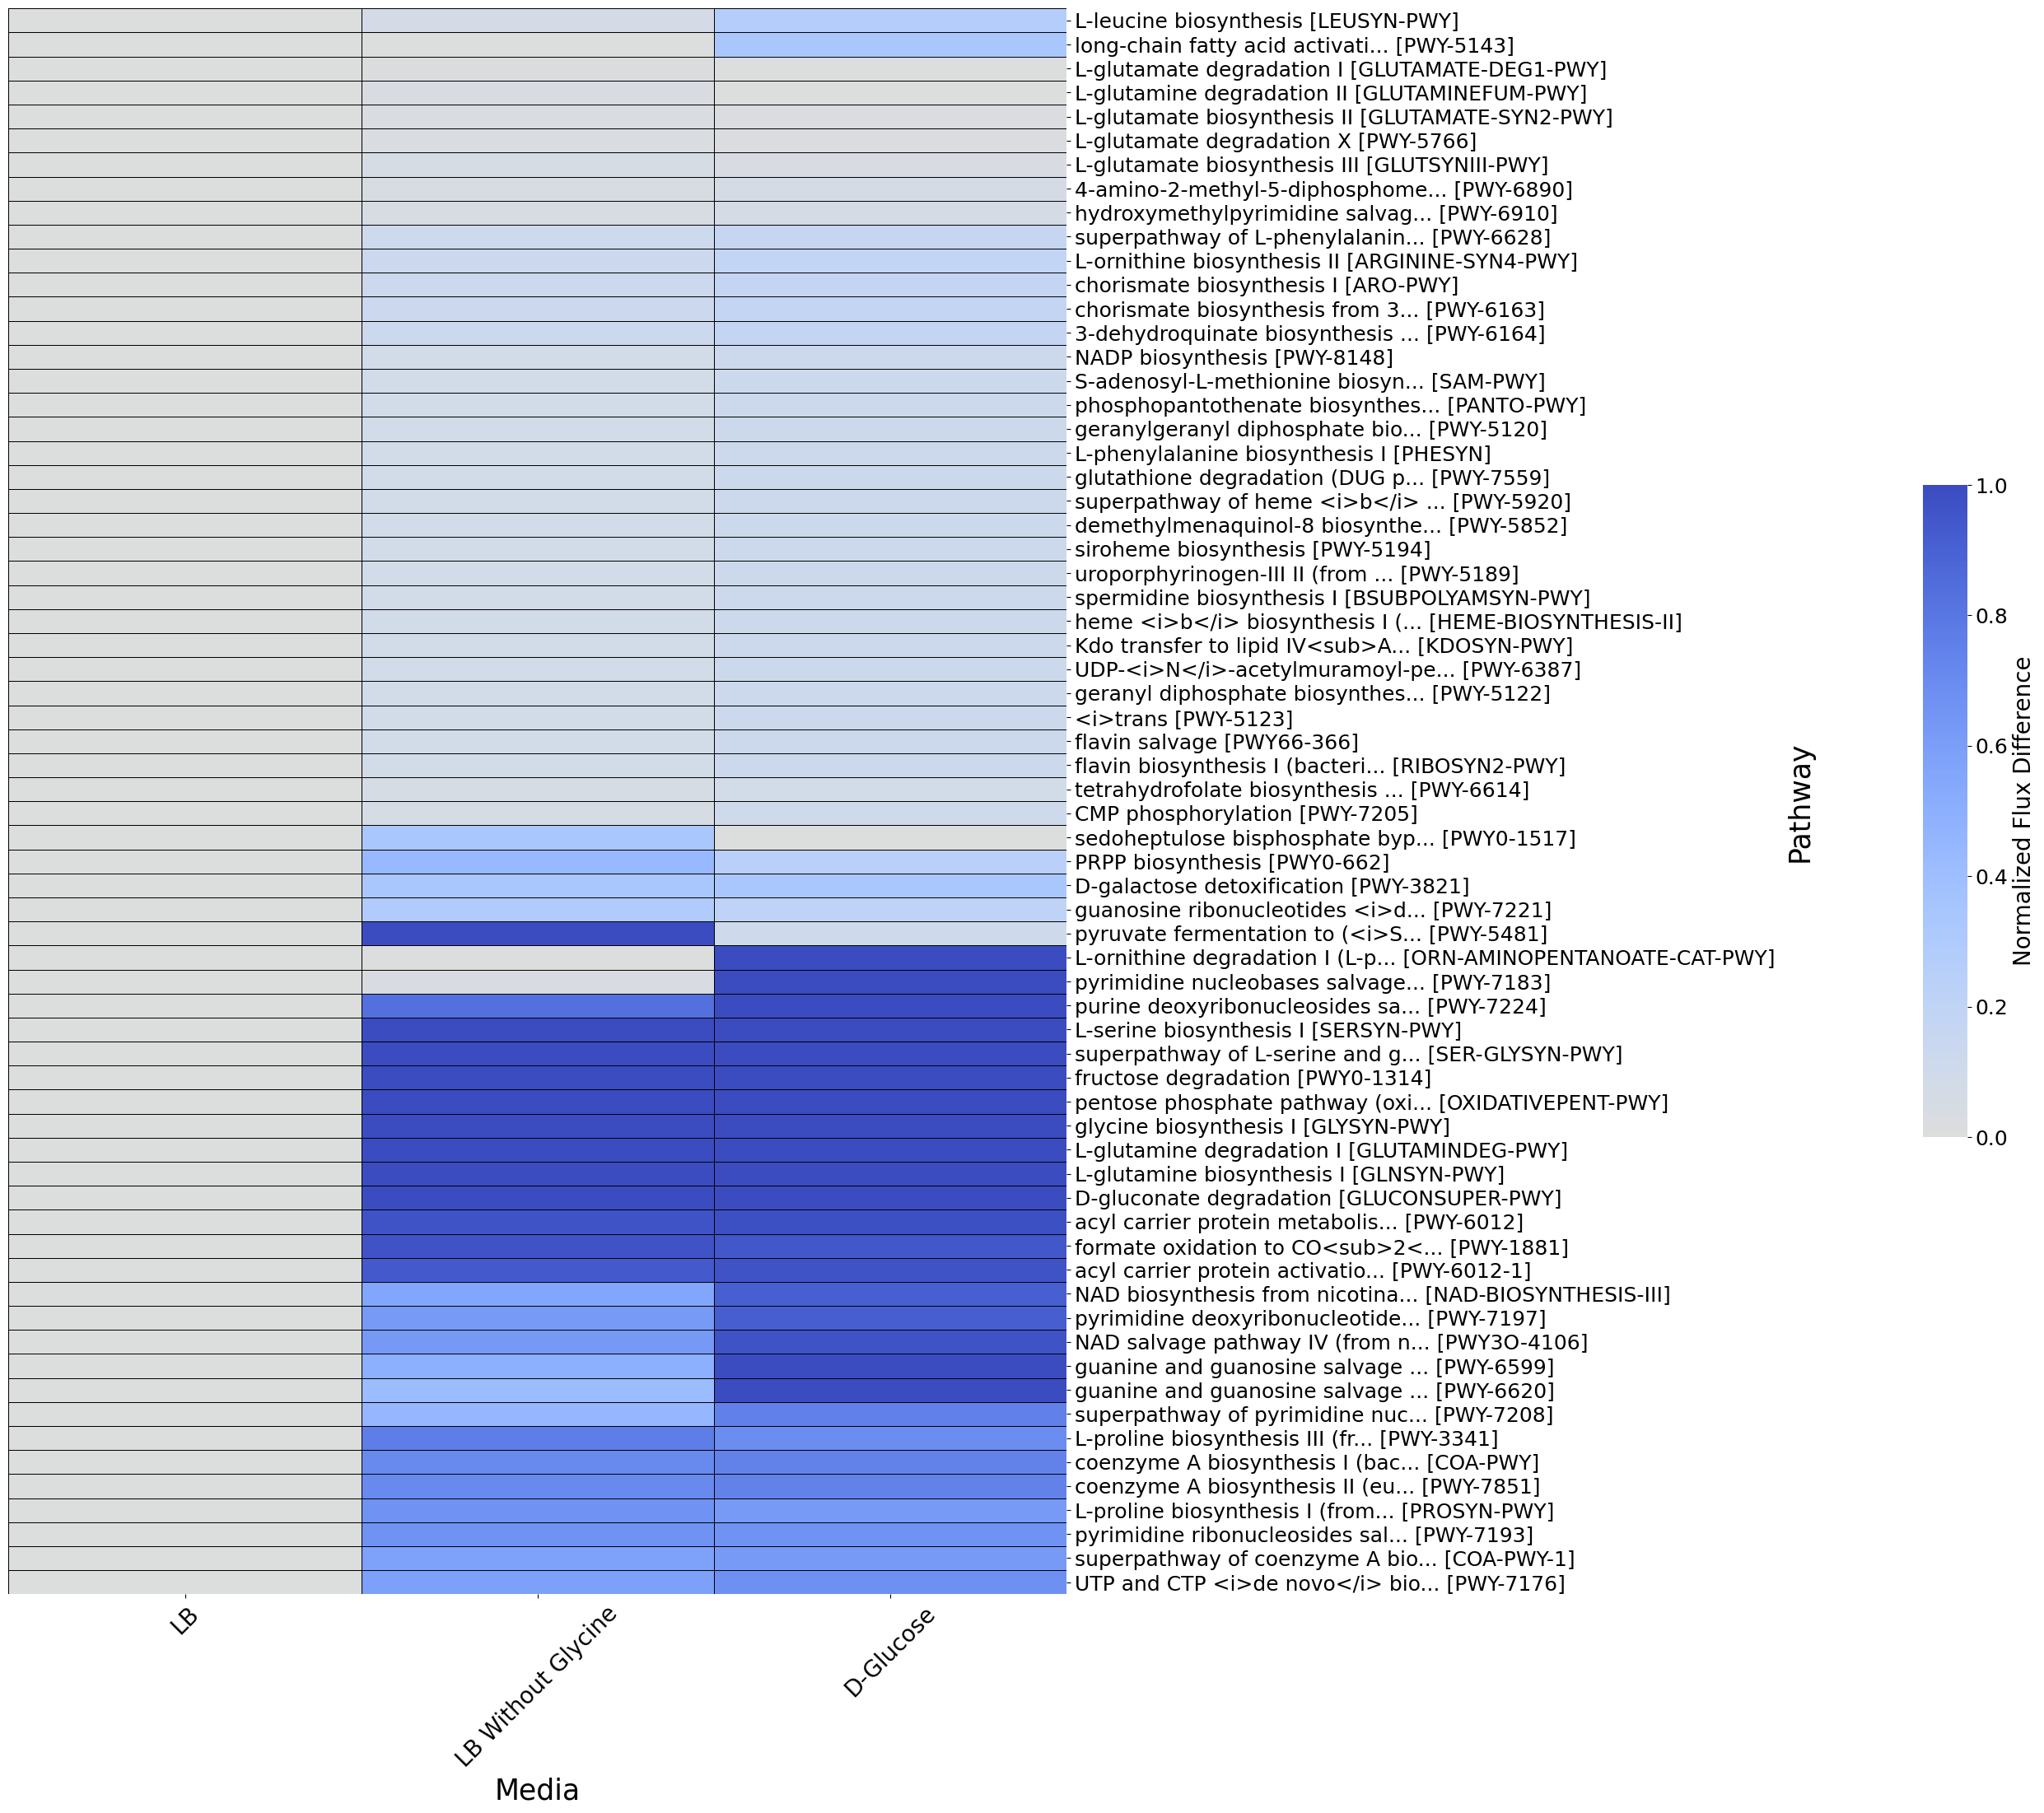

In [ ]:
#@title {display-mode: "form"}
#@markdown Heatmap showing average fluxes in kegg or metacyc modules in WT vs mutant

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
difference_type = "_normalized_difference" #@param ["_difference", "_normalized_difference"] {allow-input: false}
metric = "mean_abs_diff" #@param ["mean_diff", "mean_abs_diff"] {allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
database = "metacyc" #@param ["kegg", "metacyc"] {allow-input: false}
pathway_completeness = "1.0" #@param ["0.7", "1.0"] {allow-input: false}

# Mapping simulation approaches to indices in result arrays
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}
approach = "MOMA"

# Select appropriate database dictionaries based on user input
if database == "kegg":
    pathway_reaction_dict = kegg_reaction_module_dict
    reaction_pathway_dict = kegg_module_reaction_dict
    pathway_description = kegg_module_description
    db_annotations = kegg_annotations
    reactions_in_model = kegg_reactions_in_model
elif database == "metacyc":
    pathway_reaction_dict = metacyc_reaction_module_dict
    reaction_pathway_dict = metacyc_module_reaction_dict
    pathway_description = metacyc_module_description
    db_annotations = metacyc_annotations
    reactions_in_model = metacyc_reactions_in_model

# Load flux data from file
flux_file = working_directory + f"/simulations/" + model_name + curation + "/fluxes/" + mutant + difference_type + media_condition + ".json"

with open(flux_file, 'r') as f:
    plot_dict = json.load(f)

if create_figure == "yes":
    # Define media conditions to analyze
    media_conditions = ["LB/LB", "LB/LB_wo_glycine", "D-Glucose"]

    # ---- DATA PREPARATION ----
    # Collect flux differences by pathway
    pathway_flux_data = defaultdict(list)

    # Process each reaction's flux data
    for i in range(len(plot_dict["all_rxns"])):
        seed_rxn = plot_dict["all_rxns"][i]

        # Map reactions to database reactions and associated pathways
        if seed_rxn in db_annotations:
            for db_rxn in db_annotations[seed_rxn]:
                if db_rxn in pathway_reaction_dict:
                    associated_pathways = pathway_reaction_dict[db_rxn]

                    # Collect flux data across media conditions
                    rxn_flux_values = []
                    for media in media_conditions:
                        rxn_flux = plot_dict[media][i][approach_map[approach]]
                        rxn_flux_values.append(rxn_flux)

                    # Associate flux values with each pathway
                    for pathway in associated_pathways:
                        pathway_flux_data[pathway].append(rxn_flux_values)

    # Sort pathways alphabetically
    pathway_flux_data = {key: pathway_flux_data[key] for key in sorted(pathway_flux_data)}

    # Filter and prepare data for visualization
    filtered_pathways = []
    heatmap_data = []

    for pathway, flux_values in pathway_flux_data.items():
        # Calculate the metric of interest for each pathway
        if metric == "mean_abs_diff":
            # Average of absolute differences
            pathway_summary = [np.mean([abs(value) for value in condition_values])
                              for condition_values in zip(*flux_values)]
        elif metric == "mean_diff":
            # Average of differences (can be positive or negative)
            pathway_summary = [np.mean(condition_values)
                              for condition_values in zip(*flux_values)]

        # Calculate pathway completeness in the model
        total_rxns_in_pathway = len(reaction_pathway_dict[pathway])
        present_in_model = len(reaction_pathway_dict[pathway] & reactions_in_model)
        pathway_coverage = present_in_model / total_rxns_in_pathway

        # Include pathway if it shows differential flux and meets completeness threshold
        if (not all(round(abs(value), 2) == 0 for value in pathway_summary) and pathway_coverage >= float(pathway_completeness)):
            filtered_pathways.append(pathway)
            heatmap_data.append(pathway_summary)

    # Convert to numpy array for visualization
    data_array = np.array(heatmap_data)

    # Prepare axis labels
    column_labels = [(media_list_map[item] if item in media_list_map else item) for item in media_conditions]
    row_labels = [abbreviate_pathways(pathway_description[p].split(",")[0]) + " [" + p + "] " for p in filtered_pathways]

    # ---- VISUALIZATION ----
    # Create heatmap figure
    plt.figure(figsize=(18, max(14, len(filtered_pathways)*0.3)))

    # Generate clustered heatmap
    heatmap = sns.clustermap(
        data_array,
        annot=False,
        cmap='coolwarm_r',
        linewidths=0.5,
        linecolor='black',
        col_cluster=False,
        row_cluster=True,
        center=0,
        dendrogram_ratio=(0.0001, 0),
        cbar_pos=(1.3, 0.3, 0.03, 0.4),
        xticklabels=column_labels,
        yticklabels=row_labels,
        figsize=(18, max(14, len(filtered_pathways)*0.3))
    )

    # Style axis labels
    heatmap.ax_heatmap.set_xlabel('Media', fontsize=25)
    heatmap.ax_heatmap.set_ylabel('Pathway', fontsize=25)
    heatmap.ax_heatmap.tick_params(axis='y', labelsize=18, rotation=0)
    heatmap.ax_heatmap.tick_params(axis='x', labelsize=20, rotation=45)

    # Configure colorbar
    cbar = heatmap.fig.axes[-1]
    cbar.tick_params(labelsize=18)

    # Set appropriate colorbar label based on metric
    if difference_type == "difference":
        cbar.set_ylabel('Flux Difference (mmol/gDW h)', fontsize=20)
    elif difference_type == "_normalized_difference":
        cbar.set_ylabel('Normalized Flux Difference', fontsize=20)

    plt.show()

#### Metabolite Production in Mutant vs WT

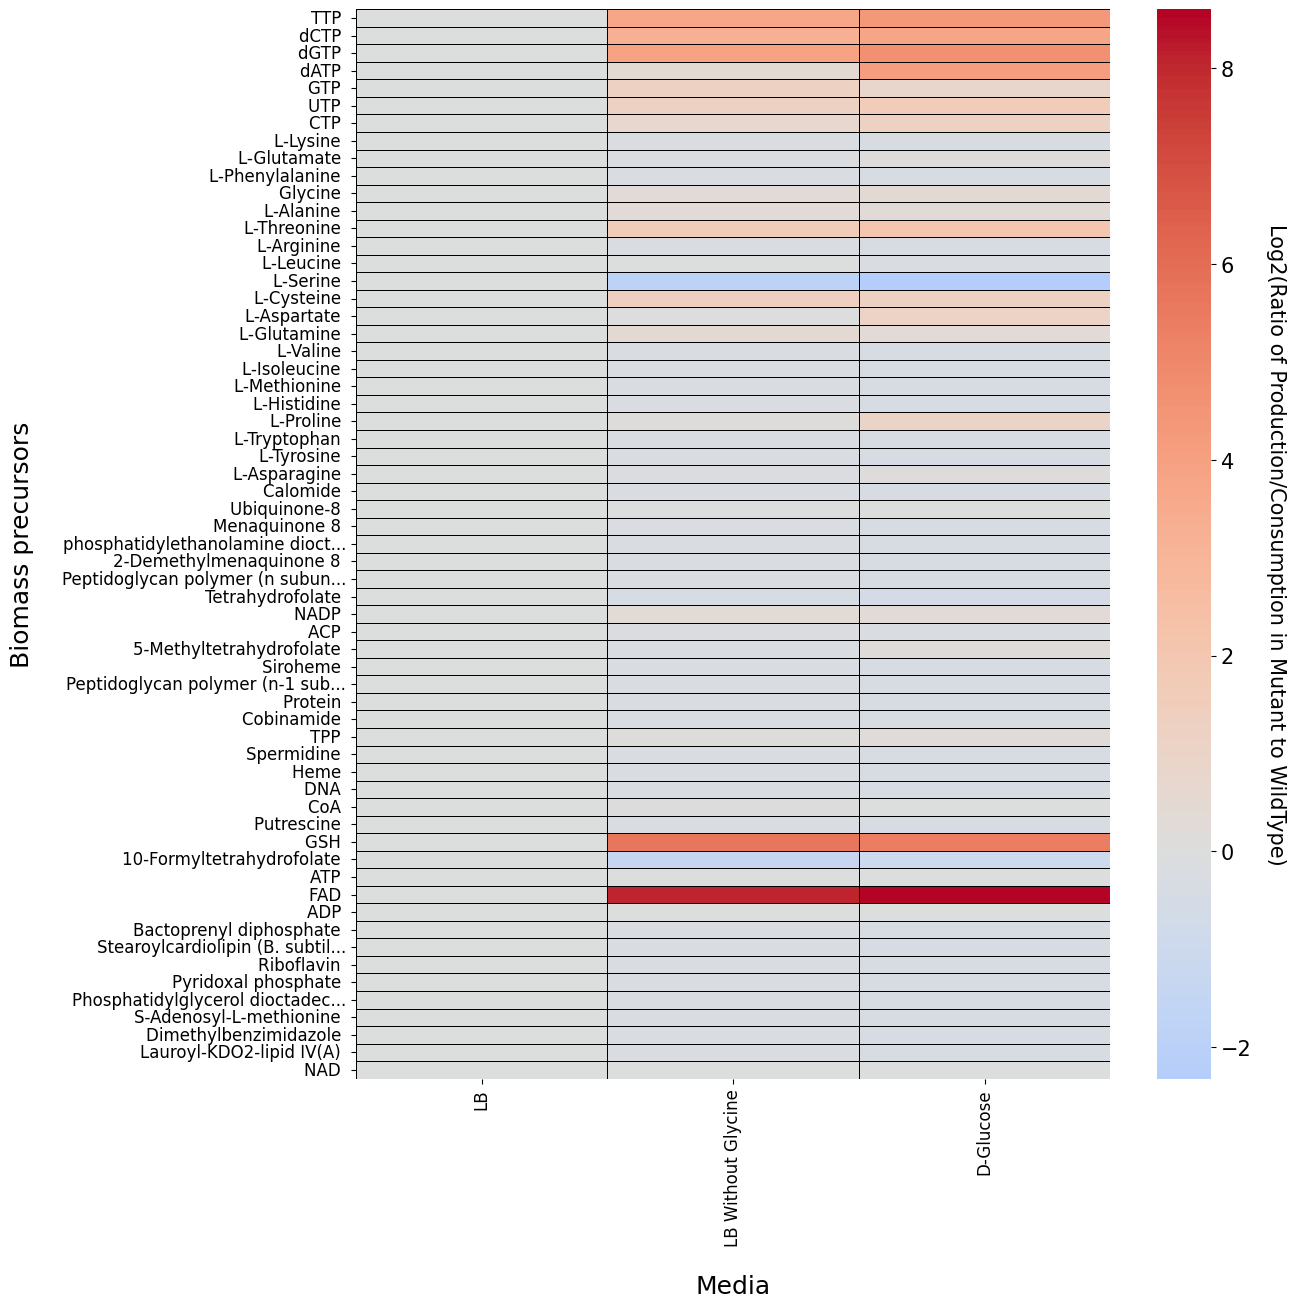

In [ ]:
#@markdown Heatmap showing the log ratio of metabolite production in mutant vs wild-type for metabolites in the biomass function.

KO_mutant = "rxn01101_c0" #@param ["rxn01101_c0"]{allow-input: false}

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

metabolite_production_file = working_directory + f"/simulations/" + model_name + curation + "/metabolite_production/" + CBA_mutant + media_condition + ".json"

# Most predictive method used for flux prediction in mutant
approach_map = {"FBA": 1, "MOMA_linear": 2, "MOMA": 3}
mutant_modeling_approach = "MOMA"

# Load metabolite production data
with open(metabolite_production_file, 'r') as f:
  production_data = json.load(f)
metabolite_list = production_data["all_metabolites"]

if create_figure == "yes":
  # Define media conditions to include in visualization
  media_list = ["LB/LB", "LB/LB_wo_glycine", "D-Glucose"] #defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  # Categorize biomass precursors based on their role in macromolecules
  if "ecoli" not in model_name:
    unique_to_DNA = DNA_precursors - mRNA_precursors - prot_precursors - biomass_precursors
    unique_to_RNA = mRNA_precursors - DNA_precursors - prot_precursors - biomass_precursors
    unique_to_protein = prot_precursors - DNA_precursors - mRNA_precursors - biomass_precursors
    others = set(all_precursors) - unique_to_DNA - unique_to_RNA - unique_to_protein - {"cpd11416_c0"}
    biomass_precursor_list = list(unique_to_DNA) + list(unique_to_RNA) + list(unique_to_protein) + list(others) + ["cpd11416_c0"]
  else:
    biomass_precursor_list = list(all_precursors)

  # Storage for filtered precursors and their production ratios
  filtered_precursors = []
  production_ratio_data = []

  # Calculate production ratios for each biomass precursor across media conditions
  for biomass_metabolite in biomass_precursor_list:
    log_ratio_values = []
    ratio_values = []
    metabolite_index = metabolite_list.index(biomass_metabolite)

    # Calculate production ratios across media conditions
    for media in media_list:
      metabolite_production = production_data[media]
      wt_production = metabolite_production[metabolite_index][0]  # WT production (first element)
      mutant_production = metabolite_production[metabolite_index][approach_map[mutant_modeling_approach]]  # Mutant production

      # Calculate ratio and log ratio of mutant vs WT production
      production_ratio = calculate_ratio(mutant_production, wt_production)
      log_production_ratio = np.log2(production_ratio)

      ratio_values.append(production_ratio)
      log_ratio_values.append(log_production_ratio)

    # Filter for metabolites with significant production differences and containing carbon
    met_has_carbon = "C" in model_0.metabolites.get_by_id(biomass_metabolite).elements
    production_differs = not all(abs(element) == 1 for element in ratio_values)

    if production_differs and met_has_carbon:
      filtered_precursors.append(biomass_metabolite)
      production_ratio_data.append(log_ratio_values)

  # Convert filtered data to numpy array for visualization
  production_ratio_array = np.array(production_ratio_data)

  # Prepare column and row labels for the heatmap
  column_labels = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  row_ids = filtered_precursors
  row_names = [abbreviate_pathways(model_0.metabolites.get_by_id(i).name.replace("[c0]",""))
                     for i in filtered_precursors]

  # Create visualization
  plt.figure(figsize=(14, 14))

  # Generate heatmap with log ratios
  ax = sns.heatmap(
      production_ratio_array,
      annot=False,
      fmt=".2f",
      cmap='coolwarm',
      center=0,
      cbar=True,
      linewidths=.5,
      linecolor='black',
      xticklabels=column_labels,
      yticklabels=row_names,
      annot_kws={"size": 12}
  )

  # Format the plot
  plt.xticks(rotation=90, fontsize=12)
  plt.yticks(rotation=0, fontsize=12)
  plt.xlabel("Media", fontsize=18, labelpad=20)
  plt.ylabel("Biomass precursors", fontsize=18, labelpad=20)

  # Adjust colorbar
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=15)
  cbar.ax.set_ylabel('Log2(Ratio of Production/Consumption in Mutant to WildType)',
                     rotation=270, fontsize=15, labelpad=25)

  # Adjust layout
  fig = plt.gcf()
  fig.tight_layout(pad=4.0)

  # Uncomment to save figure
  # figure_name = "figures/production_capacity_ratio/" + KO_mutant + model_name.replace("/","") + media_condition + ".svg"
  # plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()